<img src="https://drive.google.com/uc?export=view&id=1Yw_FWJs5dW2nyikpJLDIXnHtnfaH_6o4" width="150px" align="left" alt="pneumatic toothless dragon"><center>
<h1>How to Train Your <s>Dragon</s> Pneuomonia<h1>
<h3>Jens Schneider&nbsp&nbsp&nbsp&nbspDavid Yang</h3>
<h4>College of Science and Engineering<br/>
Hamad Bin Khalifa University</h4>
<br/>
</center>

You just got your X-ray back, you have less than 10 minutes and a crappy Chromebook. Let's figure out if you have Pneumonia or not.<br/><b>Disclaimer:</b> This is a speedrun and we shall, with reckless abandon, disregard otherwise sound advice and best practise.<img/><br/>


<b>1. Factory reset until something with >8GB shows up here.</b><br/>
Good to bad:
<ol>
<li>Tesla P100 or Tesla T4</li>
<li>Tesla K80</li>
<li>Tesla P4</li>
</ol>

In [0]:
!nvidia-smi

Tue May  5 13:58:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

<b>1b. Install fast.ai</b><br/>
Currently, Colab's fast.ai does not work with the torch version installed there.

In [0]:
!pip install -U fastai

     |████████████████████████████████| 245kB 6.2MB/s 
  Found existing installation: fastai 1.0.60
    Uninstalling fastai-1.0.60:
      Successfully uninstalled fastai-1.0.60


<b>2. Download your kaggle json API key to your local machine, upload into this cell.</b>

In [0]:
from google.colab import files
uploaded = files.upload()

import os,stat
try:    os.mkdir('/root/.kaggle')
except: pass

for fn in uploaded.keys():
  os.chmod(fn,stat.S_IRWXU)
  os.replace(fn,"/root/.kaggle/kaggle.json")

Saving kaggle (1).json to kaggle (1).json


<b>3. Download data from kaggle and unzip to shared memory (hey, we found a RAM disk...)</b><br/>

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --force
!unzip -o ./chest-xray-pneumonia.zip "chest_xray/chest_xray/*" -d /dev/shm > /dev/null
!du -h /dev/shm/chest_xray/chest_xray

100% 2.29G/2.29G [00:31<00:00, 28.4MB/s]
100% 2.29G/2.29G [00:31<00:00, 79.2MB/s]
644K	/dev/shm/chest_xray/chest_xray/val/PNEUMONIA
2.4M	/dev/shm/chest_xray/chest_xray/val/NORMAL
3.0M	/dev/shm/chest_xray/chest_xray/val
327M	/dev/shm/chest_xray/chest_xray/train/PNEUMONIA
785M	/dev/shm/chest_xray/chest_xray/train/NORMAL
1.1G	/dev/shm/chest_xray/chest_xray/train
29M	/dev/shm/chest_xray/chest_xray/test/PNEUMONIA
48M	/dev/shm/chest_xray/chest_xray/test/NORMAL
77M	/dev/shm/chest_xray/chest_xray/test
1.2G	/dev/shm/chest_xray/chest_xray


<b>4. Grab a PILlow</b><br/>
The problem with fast.ai's poor performance on Colab is the data size, 1.2GB. 6,000 images in 256x256 <b>raw</b> are only 375MB. So lets' use pillow to resize them in advance... We will use the high quality Lanczos filter to resample the image (essentially the central lobe of a sinc).


In [0]:
from PIL import Image
import glob, os
from tqdm import notebook   # coming to think of it, I believe this should be pronounced تقدم

outpath = '/dev/shm/data/'
os.system('mkdir -p '+outpath)
os.system('mkdir -p '+outpath+'/PNEUMONIA')
os.system('mkdir -p '+outpath+'/NORMAL')

# get rid of old file structure -- we're gonna partition into train and test ourselves
pneumonia_paths = ['/dev/shm/chest_xray/chest_xray/'+ty+'/PNEUMONIA/' for ty in ['test','val','train']]
normal_paths = ['/dev/shm/chest_xray/chest_xray/'+ty+'/NORMAL/' for ty in ['test','val','train']]

# get all images in pneumonia and normal paths.
pneumonia = ' '.join([' '.join(glob.glob(path+'*.jpeg')) for path in pneumonia_paths]).split()
normal =  ' '.join([' '.join(glob.glob(path+'*.jpeg')) for path in normal_paths]).split()

for n in notebook.trange(len(pneumonia),desc='PNEU'):
  image = pneumonia[n]
  nopath = image[image.rfind('/'):]    
  Image.open(image).resize((256,256),Image.LANCZOS).save(outpath+'PNEUMONIA'+nopath)

for n in notebook.trange(len(normal),desc='NORM'):
  image = normal[n]
  nopath = image[image.rfind('/'):]
  Image.open(image).resize((256,256),Image.LANCZOS).save(outpath+'NORMAL'+nopath)

# check new data size
!du -h /dev/shm/data


18M	/dev/shm/data/NORMAL
37M	/dev/shm/data/PNEUMONIA
55M	/dev/shm/data


<b>5. No time for data augmentation, just slowing us down...</b><br/>
X-ray images are fairly well calibrated anyway, due to the way they are taken at the hospital. We still normalize with <i>imagenet_stats</i>, though. <i>bs</i> is the batchsize, 64 fits into 8GB, 256 (barely) fits into 16GB GPUs.

In [0]:
from fastai.vision import *
data_path = Path('/dev/shm/data').absolute()
model_path = Path('/dev/shm/model').absolute()

data = ImageDataBunch.from_folder(data_path,
                                  valid_pct=0.2,
                                  size=256,
                                  bs=128,
                                  #ds_tfms=get_transforms(), <- This was your data augmentation
                                  no_check=True
                                 ).normalize(imagenet_stats)

<b>6. Set up the learner, use mixed precision</b><br/>
This usually matters a lot, but Colab's CPU is so restrictive that it almost does not matter.

In [0]:
learn = cnn_learner(data, 
                    models.resnet50, 
                    metrics=error_rate, 
                    model_dir=model_path
                    ).to_fp16() # <- this here sets up 16bit weights

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


<b>7. First cycle of fitting</b><br/>
This is in <i>frozen</i> state, meaning that we only update 2 million out of 25.5 million hyperparameters.

In [0]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs itlb_multihit
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management

In [0]:
learn.freeze()
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.490128,0.379983,0.096499,01:29
1,0.265826,0.212958,0.055508,01:20


KeyboardInterrupt: ignored

<b>8. Choose a learning rate for second cycle, may run multiple epochs</b><br/>
Since we're not doing data augmentation anymore, loss over learning rate can get a bit rough. You may have to disable stopping on divergence (<i>stop_div</i>) in order to see a good range (or, any range at all...). With <i>bs=128</i>, it may actually even start a 3rd epoch. The learning rate you try to find here will be used in the second cycle, that will be run in <i>unfrozen</i> state and will update all 25.5 million hyperparameters.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


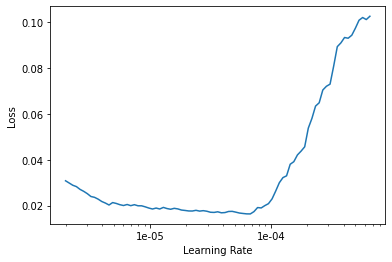

In [0]:
learn.unfreeze()
learn.lr_find(start_lr=1e-6,end_lr=1e-3,stop_div=False)
learn.recorder.plot()
learn.save(model_path / 'pre') # <- so we can recover from here

<b>9. Pick a good learning rate from the plot and go!</b><br/>
Since we skip the data augmentation, you have to be a bit more careful when picking from the above plot, and you also need some extra luck...
Then again, since this is now much faster, you can iterate a couple of times and save your best model.

In [0]:
learn.purge()                   # <- maybe not leak GPU memory into Torch
learn.load(model_path / 'pre')  # <- you can now run this cell multiple times with different learning rates
learn.fit_one_cycle(5, max_lr=1e-4)
learn.export(model_path / 'pneumonia.pkl')
learn.save(model_path / 'pneumonia')

epoch,train_loss,valid_loss,error_rate,time
0,0.026847,0.132947,0.025619,00:31
1,0.041843,0.136779,0.035867,00:31
2,0.040494,0.090376,0.027327,00:31
3,0.024515,0.078435,0.022203,00:31
4,0.014205,0.079878,0.023057,00:31


<center><b><h2>10 Minutes total with a T4 or P100...</h2></b>
<img src="https://media.giphy.com/media/l46CDHTqbmnGZyxKo/giphy.gif" alt="Excellent!"/></center>

<b>10. Download to your local filesystem</b> (optional and untested)<br/>
Or, copy to your GoogleDrive (left as an exercise)

In [0]:
# Download files to your local machine
from google.colab import files
files.download(model_path / 'pneumonia.pkl')
files.download(model_path / 'pneumonia.pth')

<b>11. Reset button to clear up the GPU's RAM</b> (optional)

In [0]:
# Clean up for next run
learn.purge()